# Mushrooms challenge

A sample solution using `predict_proba` and the ROC curve.

## 1.&nbsp;Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## 2.&nbsp; Read in, manipulate and split data

In [ ]:
url = "https://drive.google.com/file/d/1Op1vQftBKN1lrPVGGLJU-UOlv_dScTup/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
mush = pd.read_csv(path)

In [ ]:
mush.head()

,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population,Id,poisonous
0,k,e,False,w,w,v,6573,1
1,f,e,True,p,w,y,4426,0
2,b,w,False,w,w,s,7018,0
3,k,g,False,w,w,n,5789,0
4,f,n,True,p,g,v,6187,0


In [ ]:
X = mush.drop(columns=["Id"]).copy()
y = X.pop("poisonous")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=8)

X_train.head()

,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population
1725,f,g,True,w,p,y
1260,f,g,True,g,g,v
4551,x,y,False,p,b,y
2442,f,c,False,w,n,v
6109,x,g,True,g,w,v


## 3.&nbsp; Create pipeline

We chose the `RandomForestClassifier()` as our model but you can try any other classifier.

In [ ]:
pipe = Pipeline(steps=[
    ("one-hot", OneHotEncoder(drop="first", handle_unknown="ignore")),
    ("model", RandomForestClassifier(n_estimators=500, random_state=123))
])

In [ ]:
fitted_pipe = pipe.fit(X_train, y_train)

Let's plot the confusion matrix to see how well our model performed.

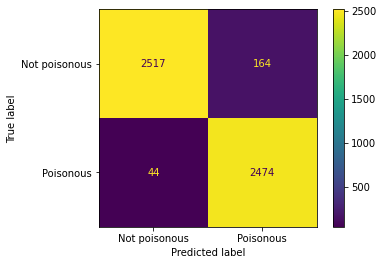

In [ ]:
ConfusionMatrixDisplay.from_estimator(fitted_pipe, X_train, y_train, display_labels=["Not poisonous", "Poisonous"]);

The confusion matrix shows that our model predicted 44 False Negatives. This means that 44 mushrooms will be predicted as non-poisonous (= Negatives) while in fact, they truly are poisonous (= False Negatives).

Our task is to avoid these situations at all costs, so we need to find a way to make that left-bottom corner of the confusion matrix to be equal to 0.

> Note: Judging from the values in the confusion matrix, the overall accuracy seems to be pretty high. As you can see from this example though, there are cases in which the accuracy doesn't seem to be the right metric to tell whether a model performs well (enough). This is why we will introduce further concepts to evaluate and tune the model below.

## 4.&nbsp; Introduction to thresholds

In order to improve our model to prevent casualties, we will now try to change the threshold with which we are predicting our classes.

**What is a threshold?**

It is a value above or below which a model predicts a different class.  
The default threshold is `0.5`, which means that if a sample has a `0.51` probability to be of class 0 and a `0.49` probability to be of class 1, the model will predict that sample to be of class 0.

In our case, this can be very dangerous because a `0.49` probability that a mushroom is poisonous is still a high chance! Unfortunately, our model with the default threshold will predict it as non-poisonous.

If you're intending to eat a mushroom, would you prefer that it is labelled as poisonous even if it's non-poisonous? Or would you prefer that the mushroom is labelled non-poisonous even though it's poisonous?

Uneaten non-poisonous mushrooms are a pity, but eaten poisonous mushrooms are a deathly risk. Therefore, we will want to change the threshold from the default `0.5` such that:
- none of the poisonous mushrooms will be labelled non-poisonous and nobody will die.
- a lot more of the non-poisonous mushrooms might be labelled as poisonous by consequence, and they will be left uneaten.

## 5.&nbsp; Get probabilities

The **`predict_proba()`** method will help us with our task.
 

`predict_proba()` is a method that many Scikit-Learn classification models have, including `LogisticRegression`, `KNeighborsClassifier`, `DecisionTreeClassifier` or the one we'll use in our example, `RandomForestClassifier`.

You can check the available methods for any Scikit-Learn transformer/model by looking at its documentation. As the [documentation for the Random Forest Classifier method](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) outlines, after fitting one of the mentioned models to the data,  `predict_proba()` will return the probabilities of each sample to belong to each possible class.

In our case, for each mushroom, `predict_proba()` will tell us both the probability of that mushroom being non-poisonous (class 0) and poisonous (class 1). Let's have a look:

In [ ]:
probabilities = fitted_pipe.predict_proba(X_train)
probabilities_df = pd.DataFrame(probabilities)
probabilities_df

,0,1
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0
...,...,...
5194,0.0,1.0
5195,0.0,1.0
5196,1.0,0.0
5197,1.0,0.0


The `probabilities` array has a shape of (5199,2):
* 5199 is the number of mushroooms in our X_train dataset  
* 2 is the number of classes, in our case 0 and 1 (non-poisonous and poisonous)  

The first column holds the values of probabilites for a mushroom being of class 0.  
The second column holds the values of probabilites for a mushroom being of class 1.

Both probabilities add up to 1 for each mushroom.

If we want to know for each mushroom, with which probability it is considered to be poisonous, we need to look at all the values in the second column.

In [ ]:
probabilities_df.loc[:,1].unique()

array([0.        , 1.        , 0.57228434, 0.82154437, 0.64652661,
       0.998     , 0.79205862, 0.55791547, 0.91100676, 0.28372519,
       0.69007378, 0.95817943, 0.67169039, 0.51830389, 0.002     ,
       0.01038699, 0.95303896, 0.93231455, 0.23299817, 0.56311701,
       0.00534615, 0.94336611, 0.994     , 0.008     , 0.676     ,
       0.00925152, 0.0012    , 0.012     , 0.21447552, 0.0025    ,
       0.66194763, 0.004     , 0.00135   , 0.71272538, 0.328     ,
       0.02780252, 0.978     , 0.25273456, 0.00479446, 0.91465177,
       0.988     , 0.97714832, 0.986     , 0.9865    , 0.94322129,
       0.00589091, 0.108     , 0.02646864, 0.01136398, 0.00108108,
       0.05948566, 0.01150159, 0.006     , 0.018     , 0.98321156,
       0.95026857, 0.038     , 0.992     , 0.71613097, 0.02      ])

## 6.&nbsp; ROC and threshold selection

ROC and AUC will help us with choosing the treshold. Please go through the material linked below to learn about these important metrics for binary classification. It will help you understand the rest of the notebook:  
* https://www.kaggle.com/getting-started/53782  
* https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
* https://www.youtube.com/watch?v=4jRBRDbJemM

The `roc_curve()` function computes the effect of applying different thresholds. For each of these models, it returns three values that are stored in arrays:

1. An array with the false positive rates (= how many of the true negatives were incorrectly classified as positive).
2. An array with the true positive rates (= how many of the true positives were correctly classified as such).
3. An array with the threshold that determines the results obtained in the two previous arrays.

More on the `roc_curve()` function here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

> Note: Since in our dataset, a 1 in the poisonous column corresponds to the mushroom being poisonous, this is our "positive" class. The non-poisonous mushrooms, denoted with a 0, form the "negative" class. We want all poisonous (= positive) mushrooms to be labelled as such. Therefore, we want the true positive rate to be equal to 1.

In [ ]:
# Use the y_train and the probability estimates of the positive (=poisonous) class.
# Returns three arrays with false positive rates, false negative rates and the thresholds.

fpr, tpr, threshold = roc_curve(y_train, probabilities[:,1])

We can visualize the data in these arrays using a ROC plot.

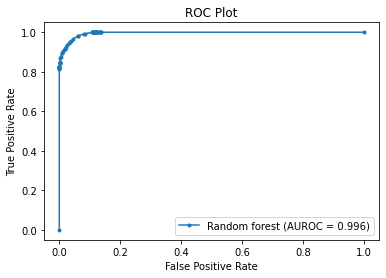

In [ ]:
# AUC denotes the area under the ROC curve.
auc = roc_auc_score(y_train, probabilities[:,1])

plt.plot(fpr, tpr, marker=".", label="Random forest (AUROC = %0.3f)" % auc)

# Title
plt.title("ROC Plot")
# Axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# Show legend
plt.legend()
# Show plot
plt.show()

We can see on above ROC plot that the true positive rate becomes 1 when the false positive rate is around 0.3. Let's check the value of the threshold when the true positive rate is 1.

For that purpose, we will first create a dataframe from the false positive rate, true positive rate and threshold arrays that we got from the roc_curve function.

In [ ]:
roc_df = pd.DataFrame({"fpr":fpr,"tpr":tpr,"threshold":threshold})
roc_df

,fpr,tpr,threshold
0,0.000000,0.000000,2.000000
1,0.000000,0.814138,1.000000
2,0.000000,0.819698,0.998000
3,0.000000,0.820492,0.992000
4,0.000000,0.822081,0.986500
5,0.000000,0.823670,0.986000
6,0.000000,0.824067,0.983212
7,0.000000,0.824861,0.978000
8,0.000000,0.825258,0.977148
9,0.000746,0.843924,0.958179


Lets take one row of the DataFrame above to explain the values.

In [ ]:
roc_df.loc[16]

fpr          0.009325
tpr          0.897141
threshold    0.716131
Name: 16, dtype: float64

This row means that if we set the threshold to `0.716`, the false positive rate will be almost `0.009` and the true positive rate will be `0.897`.

It means that for that threshold, 0,9% of all non-poisonous mushrooms will be (incorrectly) labelled as poisonous, and 89.7% of all poisonous mushrooms will be correctly labelled as such.

Since our task is to **not** predict poisonous as non-poisonous, we should have 0 false negatives, and our true positive rate has to be equal to 1 (100% of poisonous get labelled as poisonous).

Visually examining the above DataFrame, we can see that the true positive rate increases from 0 to 1 and finally reaches 1 in row 31. In that same row, the threshold value is `0.21`, and that is the one we will choose to filter our results.

In [ ]:
optimum_threshold_value = roc_df.threshold[31]
optimum_threshold_value

0.21447551951316687

We encourage you to scan the results shown above, but here's a slightly more automated way to find the best threshold:

In [ ]:
roc_df[roc_df["tpr"] == 1].nlargest(1, "threshold")

,fpr,tpr,threshold
31,0.108915,1.0,0.214476


## 7.&nbsp; Adjust predictions based on the threshold value

The following code generates the predicted values based on the probability 
of a sample being a class 1 (of a mushroom to be poisonous) that `predicted_proba()` returned.

If a mushroom's probability is higher than the threshold, its prediction will be 1 (poisonous). The prediction will only be 0 (non-poisonous) if the probability is lower than the threshold.

In [ ]:
# Select only the column with the poisonous probabilities.
# Compare each probability with the threshold value. This returns Boolean values.
# Transform the Boolean values into integers (i.e. 0 and 1).
new_predictions = (probabilities_df.loc[:,1] >= optimum_threshold_value).astype("int")

In [ ]:
# Print the values in rows 4-8 from both the probabilities and the prediction.
# Check how the probabilities are set based on the predicted_proba values:
print(f"Probability: {probabilities_df.loc[40, 1]}")
print(f"New Value: {new_predictions.loc[40]}")

Probability: 0.28372519436406807
New Value: 1


Let's plot another confusion matrix, this time using the results from the adjusted threshold and seaborn.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# Generate the confusion matrix, this time using the predictions and y_train.
cf_matrix = confusion_matrix(y_train, new_predictions)

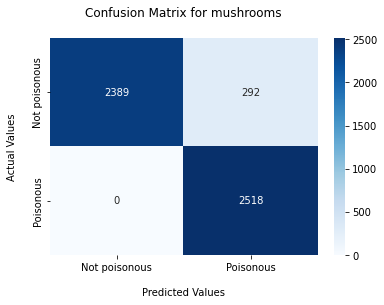

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")

ax.set_title("Confusion Matrix for mushrooms\n");
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values\n");

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Not poisonous","Poisonous"])
ax.yaxis.set_ticklabels(["Not poisonous","Poisonous"])

## Display the visualization of the Confusion Matrix.
plt.show()

SUCCESS! Using the adjusted threshold, none of the poisonous mushrooms got a false prediction.

## 8.&nbsp; Check performance with test dataset

As usual, we want to check our model's performance using the test dataset.

In [ ]:
# Use the pipeline to determine the probabilities.
probabilities_test_set = fitted_pipe.predict_proba(X_test)

# Use the probabilities and the threshold to make the predictions.
predicted_test = (probabilities_test_set[:,1] >= optimum_threshold_value).astype("int")

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


In [ ]:
# Create the confusion matrix using the predictions from the test dataset and y_test.
matrix_test = confusion_matrix(y_test, predicted_test)

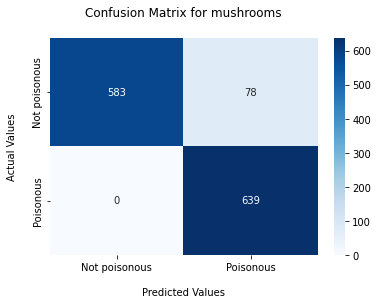

In [ ]:
ax = sns.heatmap(matrix_test, annot=True, cmap="Blues", fmt="g")

ax.set_title("Confusion Matrix for mushrooms\n");
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values\n");

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Not poisonous","Poisonous"])
ax.yaxis.set_ticklabels(["Not poisonous","Poisonous"])

## Display the visualization of the Confusion Matrix.
plt.show()

SUCCESS! The threshold has also filtered out all the poisonous mushrooms from the test dataset!